# Data Loader?
- hi

In [35]:
import os
import numpy as np
import librosa
from tensorflow.keras.utils import Sequence

In [37]:
import threading, sys, os
import time
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import optimizers
from collections import namedtuple

In [38]:
import numpy as np
from src.util.global_function import mkdir_p


In [39]:
from src.util.math_function import create_padding_mask, create_look_ahead_mask
from src.losses.custom_loss import mse_with_proper_loss, MSE_Custom_Loss_No_Length, pit_with_outputsize, pit_with_stft_trace
from src.models.Layers import TransformerSpeechSep
from src.models.Schedulers import CustomSchedule
from src.models.Real_Layers import T5Model, T5ModelNoMaskCreationModel, T5ModelYesMaskCreationModel
from src.pre_processing.data_pre_processing import load_data
from src.models.T5_variations import T5ChangedSTFT

In [100]:
Config = namedtuple('Config',  
    field_names="d_ff,     d_kv,     d_model,              dropout, feed_forward_proj, num_layers, init_factor," 
                "layer_norm_epsilon, model_type, num_heads, positional_embedding, n_epochs, vocab_size, relative_attention_num_buckets,"
                    "model_path, wav_type, size_type, train_type, loss_type, learning_rate_type,"
                    "input_size, output_size, batch_size, case, ckpt_path, tr_path, val_path, tt_path,"
                    "test_wav_dir, is_load_model")
args = Config( 2048      , 64      , 512              , 0.1 , "gated-gelu", 4       , 1.,
                1e-06    , "t5"             , 8 , "absolute" , 5     , 129   , 32,
                "CKPT", "wav8k", "min", "train-360", "mse", "inverse_root",
                40, 40, 25, 'trace', 'C:/J_and_J_Research/mycode/CKPT', 
                'C:/J_and_J_Research/mycode/wsj0_2mix/use_this/tr/', 
                'C:/J_and_J_Research/mycode/wsj0_2mix/use_this/cv/',
                'C:/J_and_J_Research/mycode/wsj0_2mix/use_this/tt/', 
                'C:/J_and_J_Research/mycode/test_wav',
                True) 

In [101]:

def create_masks(inp, tar, length=None):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp, length) # (batch, 1, 1, seq_len)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp, length)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1]) # (seq_len, seq_len)
    dec_target_padding_mask = create_padding_mask(tar, length) # (batch, 1, 1, seq_len)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask) # (batch, 1, seq_len, seq_len)

    return enc_padding_mask, combined_mask, dec_padding_mask

# Raw 1Conv Layer 
- 주원씨가 만든 raw data를 conv로 embedding한거 클래스임니다.

In [102]:
class RawDataGenerator(Sequence):
    def __init__(self, Mix, wav_dir, files, batch_size=10, shuffle=True):
        self.Mix = Mix
        self.wav_dir = wav_dir
        self.files = files
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.Mix))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __audioread__(self, path, offset=0.0, duration=None, sample_rate=16000):
        signal = librosa.load(path, sr=sample_rate, mono=False, offset=offset, duration=duration)

        return signal[0]
    
    def __padding__(self, data):
        n_batch = len(data)
        max_len = max([d.shape[0] for d in data])
        pad = np.zeros((n_batch, max_len, data[0].shape[1]))
        
        for i in range(n_batch):
            pad[i, :data[i].shape[0]] = data[i]
        
        return pad
        
    def __data_generation__(self, Mix_list):
        sample_rate = 8000
        L = 40
        
        mix_wav_list = []
        label_wav_list = []
        for name in Mix_list:
            name = name.strip('\n')
            
            s1_wav_name = self.wav_dir + self.files + '/s1/' + name
            
            # ------- AUDIO READ -------
            s1_wav = (self.__audioread__(s1_wav_name,  offset=0.0, duration=None, sample_rate=sample_rate))
            # --------------------------
            
            # ------- TIME AXIS CALCULATE -------
            K = int(np.ceil(len(s1_wav) / L))
            # -----------------------------------
            
            # ------- PADDING -------
            pad_len = K * L
            pad_s1 = np.concatenate([s1_wav, np.zeros([pad_len - len(s1_wav)])])
            # -----------------------
            
            # ------- RESHAPE -------
            s1 = np.reshape(pad_s1, [K, L])
            # -----------------------
            
            # ------- CONCAT S1 S2 -------
            # ----------------------------
            
            label_wav_list.append(s1)
        
        return label_wav_list, label_wav_list

    
    def __len__(self):
        return int(np.floor(len(self.Mix) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        Mix_list = [self.Mix[k] for k in indexes]
        
        if self.files is not 'tt':
            mix, labels = self.__data_generation__(Mix_list)
            
            # Get Lengths(K value of each batch)
            lengths = np.array([m.shape[0] for m in mix])
            tiled = np.tile(np.expand_dims(lengths, 1), [1, labels[0].shape[1]])
            tiled = np.expand_dims(tiled, 1)
            
            # Padding
            mix_pad = self.__padding__(mix) # [Batch, Time_step, Dimension]
            label_pad = self.__padding__(labels) # [Batch, Time_step, Dimension * 2]
            
            return mix_pad, np.concatenate([label_pad, tiled], axis=1), lengths
        else:
            mix, labels = self.__data_generation__(Mix_list)
            
            # Get Lengths(K value of each batch)
            lengths = np.array([m.shape[0] for m in mix])
            tiled = np.tile(np.expand_dims(lengths, 1), [1, labels[0].shape[1]])
            tiled = np.expand_dims(tiled, 1)
            
            # Padding
            mix_pad = self.__padding__(mix) # [Batch, Time_step, Dimension]
            
            return mix_pad, tiled, lengths

In [103]:
WAV_DIR = './mycode/wsj0_2mix/use_this/'
LIST_DIR = './mycode/wsj0_2mix/use_this/lists/'

In [104]:
# Directory List file create
wav_dir = WAV_DIR
output_lst = LIST_DIR

for folder in ['tr', 'cv', 'tt']:
    wav_files = os.listdir(wav_dir + folder + '/mix')
    output_lst_files = output_lst + folder + '_wav.lst'
    with open(output_lst_files, 'w') as f:
        for file in wav_files:
            f.write(file + "\n")

print("Generate wav file to .lst done!")

Generate wav file to .lst done!


In [105]:
batch_size = 2

train_dataset = 0
valid_dataset = 0
test_dataset = 0

name_list = []
for files in ['tr', 'cv', 'tt']:
    # --- Lead lst file ---
    output_lst_files = LIST_DIR + files + '_wav.lst'
    fid = open(output_lst_files, 'r')
    lines = fid.readlines()
    fid.close()
    # ---------------------
    
    if files == 'tr':
        train_dataset = RawDataGenerator(lines, WAV_DIR, files, batch_size)
    elif files == 'cv':
        valid_dataset = RawDataGenerator(lines, WAV_DIR, files, batch_size)
    else:
        test_dataset = RawDataGenerator(lines, WAV_DIR, files, batch_size)

In [113]:
def build_real_T5(input_size, output_size, args):
    inputs = (tf.keras.layers.Input(shape=(None, input_size)),
    tf.keras.layers.Input(shape=(None, output_size)),
    tf.keras.layers.Input(shape=(1)) )
    # targets, length
        
    transformer = T5ModelNoMaskCreationModel(num_layers=args.num_layers, d_model=args.d_model, num_heads=args.num_heads, d_ff=args.d_ff, d_kv = args.d_kv, vocab_size=0, feed_forward_proj = args.feed_forward_proj, 
            relative_attention_num_buckets=args.relative_attention_num_buckets, eps=args.layer_norm_epsilon, dropout=args.dropout, factor=args.init_factor,
            embed_or_dense="conv", target_size=output_size)

    inp, tar, length = inputs
    #dec_padding_mask = tf.squeeze(dec_padding_mask)
    #outputs = tf.keras.layers.Conv1D(filters=129, kernel_size=2, activation = 'sigmoid', padding='same')(inp)

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar, length)
    enc_padding_mask = tf.squeeze(enc_padding_mask)
    outputs = transformer(input_ids=inp, attention_mask=enc_padding_mask, 
            decoder_input_ids=tar, 
             training=False) # (batch_size, tar_seq_len, target_vocab_size)
    
    model = T5ChangedSTFT(inputs=inputs, outputs=outputs)
    model.summary()
    learning_rate = CustomSchedule(args.d_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-8)
    #optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,epsilon=1e-8, weight_decay = 0.01)
    #model.add_metric(tf.keras.metrics.Mean(name='train_loss')(outputs))
    #model.compile(loss=mse_with_proper_loss(output_size), optimizer=optimizer)
    model.compile(loss=pit_with_stft_trace(output_size), optimizer=optimizer)
#     model.compile(loss=keras.losses.mean_squared_error, optimizer=adam)

    return model


In [114]:
ckpt_path = args.ckpt_path
mkdir_p(ckpt_path) # model check point 폴더 만드는 코드

filepath = ckpt_path + "/CKP_ep_{epoch:d}__loss_{val_loss:.5f}_.h5"

# validation loss에 대해서 좋은 것만 저장됨
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True
)

# early stop 하는 부분인데, validation loss에 대해서 제일 좋은 모델이 저장됨
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True
)

# Training part

epoch = args.n_epochs
strategy = tf.distribute.MirroredStrategy() # '/gpu:0','/gpu:1','/gpu:2','/gpu:4','/gpu:5','/gpu:6','/gpu:7'
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[0:7], 'GPU')
#strategy =  tf.distribute.MultiWorkerMirroredStrategy()
print('장치의 수: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    # 사용 안할 때는 load_model 주석 처리 하자
#     model = load_model('./CKPT/CKP_ep_29__loss_102.63367_.h5', custom_objects={'pit_loss': pit_with_outputsize(OUTPUT_SIZE)})

    model = build_real_T5(args.input_size, args.output_size, args)
    #if args.is_load_model is True:

    tf.executing_eagerly()

history = model.fit(
    train_dataset,
    epochs=epoch,
    validation_data=valid_dataset,
    shuffle=True,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
장치의 수: 1
Model: "t5_changed_stft_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, None, 40)]   0                                            
__________________________________________________________________________________________________
input_57 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape_68 (TFOpLamb (3,)                 0           input_55[0][0]                   
__________________________________________________________________________________________________
tf.compat.v1.squeeze_68 (TFOpLa None                 0           inpu

In [115]:
# Show training and validation loss graph

def graph_util(history):
    fig = plt.figure()
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(history.history['loss'], c='b')
    plt.plot(history.history['val_loss'], c='r')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper left')
    
    plt.show()

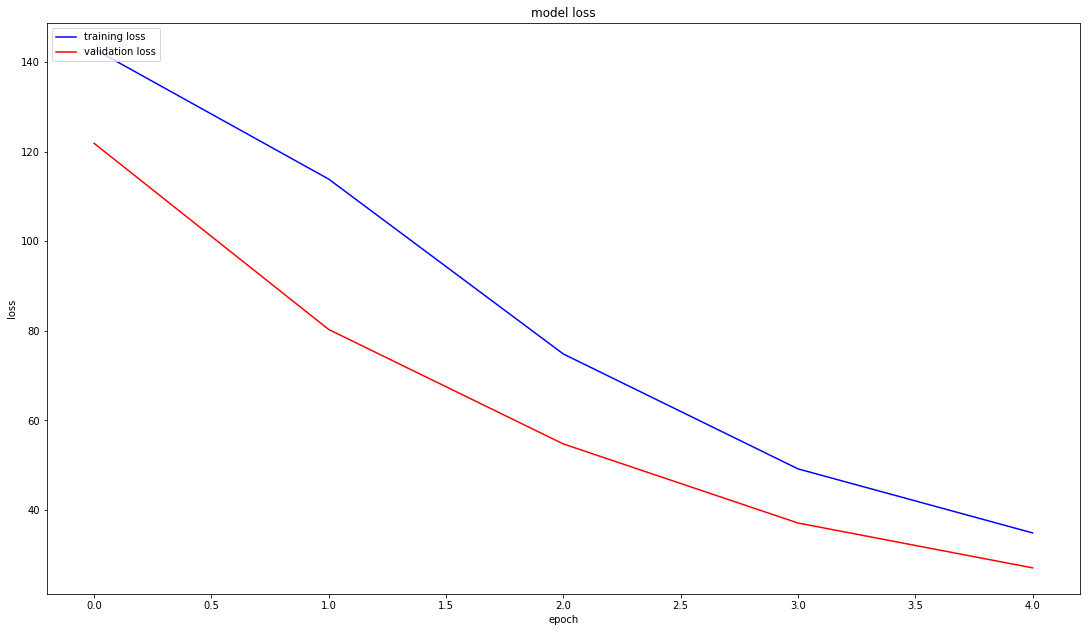

In [116]:
graph_util(history)

In [111]:

import matplotlib
import matplotlib.pyplot as plt